Part a) Ordinary Least Square (OLS) for the Runge function

In [23]:
#Starting by generating point of x in the interval [-1,1]

import numpy as np 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#choosing datapoints between 1 and -1 
n = 100
x = np.linspace (-1,1, n)


#From the Runge function: for every x, compute the correspponding y
y = 1/(1 + 25 * x**2)
#Adding noise (Gaussian) with mean 0 and variance 1: N(0,1)
noise = np.random.normal(0,1,n)
y_noisy = y + 0.1 * noise


#Creating feature matrix with shape [1,x,x^2,x^3,x^4 ...]
def polynomial_features(x, p, intercept = True):
    n = len(x)
    if intercept == True: # adding functionality for intercept
        X = np.zeros((n, p + 1))
        X[:, 0] = 1  # intercept column first
        for i in range(1, p + 1): # from 1 to p inclusive
            X[:, i] = x ** i
    else: #if intercept is False
            X = np.zeros((n, p)) #no intercept column
            for i in range(p): #from 0 to p-1
                X[:, i] = x ** (i + 1) 

    return X

def OLS_parameters(X, y):
    X_T_X = np.linalg.pinv(X.T @ X)
    beta_OLS = X_T_X @ X.T @ y
    return beta_OLS

def R2_score(actual , predicted):
     numerator = np.sum((actual - predicted) ** 2) #the numerator of the r2 formula
     actual_mean = np.mean(actual) #our mean value of the actual values
     denominator = np.sum((actual - actual_mean) ** 2) #denominator of the r2 formula
     R2 = 1 - (numerator / denominator) #calculating the r2
     return R2




In [25]:
#we start by creating the design matrix and splitting it into training and test data
X = polynomial_features(x, 15)
X_train , X_test , y_train , y_test = train_test_split(X , y_noisy , test_size = 0.2)


#thereby calculating the OLS coefficients
beta = OLS_parameters(X_train, y_train)
y_pred = X_test @ beta #here we predict the y values using the coefficient calculated

mse_y_pred = mean_squared_error(y_test , y_pred) # calculating the MSE
R2 = R2_score(y_test , y_pred) #calculating the R2 score



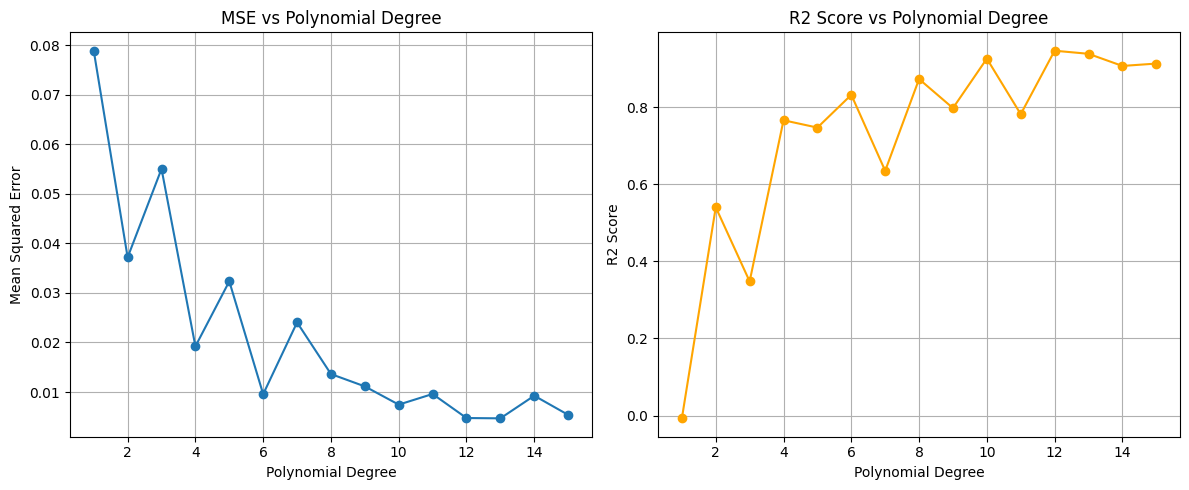

In [27]:
import matplotlib.pyplot as plt

mse_values = np.zeros(15) #storing the mse values for each polynomial degree
R2_values = np.zeros(15) #storing the r2 values for each polynomial

for i in range(1 , 16):
    X = polynomial_features(x , i)
    X_train , X_test , y_train , y_test = train_test_split(X , y_noisy , test_size = 0.2)
    beta = OLS_parameters(X_train , y_train)
    y_pred = X_test @ beta
    mse_values[i-1] = mean_squared_error(y_test , y_pred)
    R2_values[i-1] = R2_score(y_test , y_pred)


#now we create degrees array as well
degrees = np.arange(1 , 16)
plt.figure(figsize = (12 , 5))
plt.subplot(1 , 2 , 1)
plt.plot(degrees , mse_values , marker = 'o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Polynomial Degree')
plt.grid()
plt.subplot(1 , 2 , 2)
plt.plot(degrees , R2_values , marker = 'o' , color = 'orange')
plt.xlabel('Polynomial Degree')
plt.ylabel('R2 Score')
plt.title('R2 Score vs Polynomial Degree')
plt.grid()
plt.tight_layout()
plt.show()